In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

# Loading the Dataset
df = pd.read_csv("C:/Project Entri/Pre_processed_ipl_data.csv")

In [2]:
# making the second innings data
df['match_date'] = pd.to_datetime(df['match_date'])
second_innings_df = df[df['Innings'] == 2].copy()
second_innings_df.sort_values(by=['ID_x', 'Overs', 'BallNumber'], inplace=True)
second_innings_df['cum_runs'] = second_innings_df.groupby('ID_x')['TotalRun'].cumsum()
second_innings_df['cum_wickets'] = second_innings_df.groupby('ID_x')['IsWicketDelivery'].cumsum()

# target for second innings
first_innings_df = df[df['Innings'] == 1]
target_runs = first_innings_df.groupby('ID_x')['TotalRun'].sum().reset_index()
target_runs.columns = ['ID_x', 'target']
second_innings_df = pd.merge(second_innings_df, target_runs, on='ID_x')

second_innings_df['balls_bowled'] = second_innings_df['Overs'] * 6 + (second_innings_df['BallNumber'] - 1)
second_innings_df['balls_left'] = 120 - second_innings_df['balls_bowled']
second_innings_df['runs_left'] = second_innings_df['target'] - second_innings_df['cum_runs']
second_innings_df['wickets_left'] = 10 - second_innings_df['cum_wickets']
second_innings_df['current_run_rate'] = second_innings_df['cum_runs'] / ((second_innings_df['balls_bowled'] + 1) / 6)
second_innings_df['required_run_rate'] = second_innings_df['runs_left'] / ((second_innings_df['balls_left'] + 1) / 6)
second_innings_df['batting_team_won'] = (second_innings_df['BattingTeam'] == second_innings_df['winner']).astype(int)

data = second_innings_df[[ 
    'BattingTeam', 'team1', 'team2', 'venue',
    'cum_runs', 'runs_left', 'cum_wickets', 'wickets_left', 'balls_left',
    'current_run_rate', 'required_run_rate', 'target', 'batting_team_won'
]].copy()

In [3]:
# handling the missing ddata
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)

# encoding cateorical column
encoders = {}
for col in ['BattingTeam', 'team1', 'team2', 'venue']:
    encoders[col] = LabelEncoder()
    data[col] = encoders[col].fit_transform(data[col])

In [4]:
# matrix and target
X = data.drop('batting_team_won', axis=1)
y = data['batting_team_won']
# training and testing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


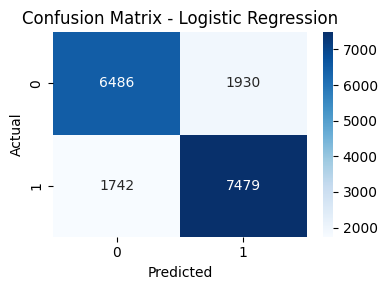

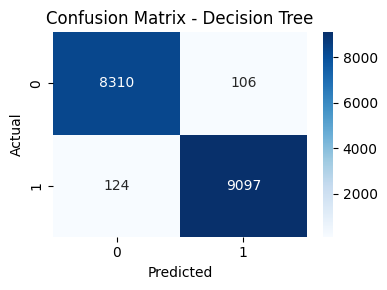

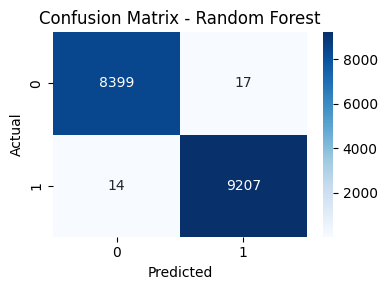

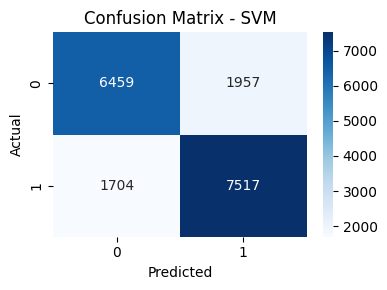

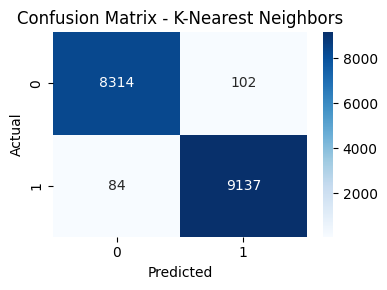

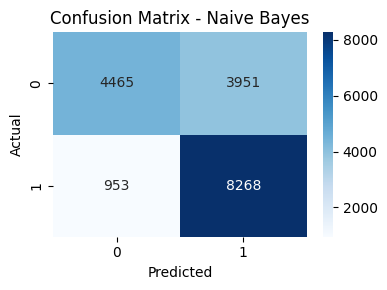

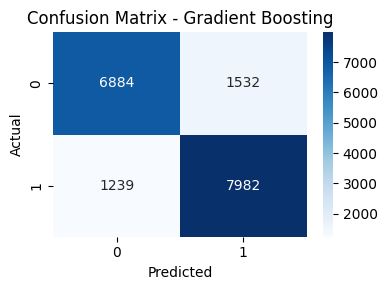

In [5]:
# model training
models = {
    "Logistic Regression":make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000)),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "SVM": make_pipeline(StandardScaler(), SVC(kernel='linear', probability=True)),
    "K-Nearest Neighbors": make_pipeline(StandardScaler(), KNeighborsClassifier()),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier()
}

accuracy_results = {}
f1_results = {}

# training the models
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    accuracy_results[name] = acc
    f1_results[name] = f1

    # 🔷 Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

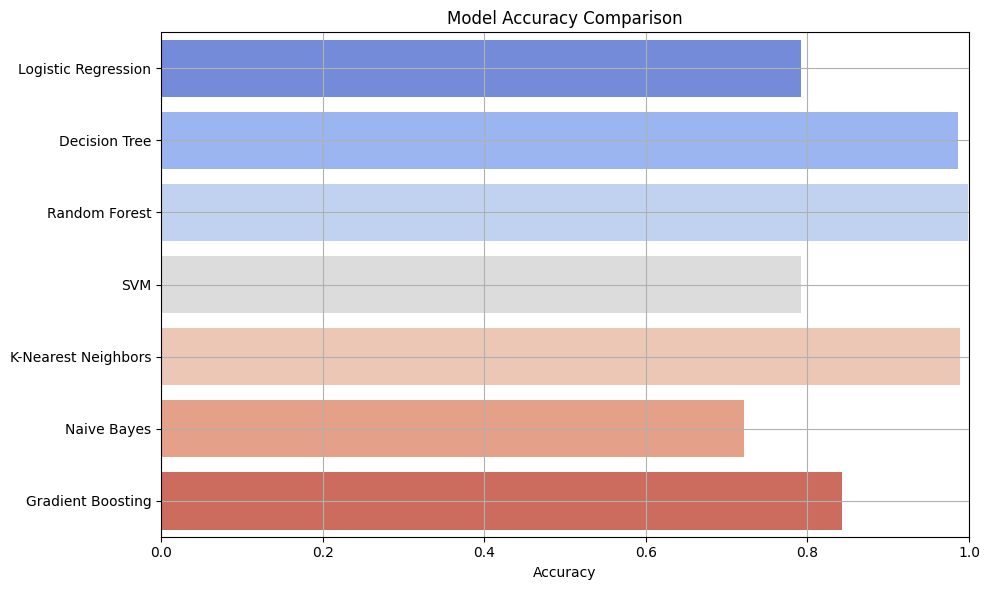

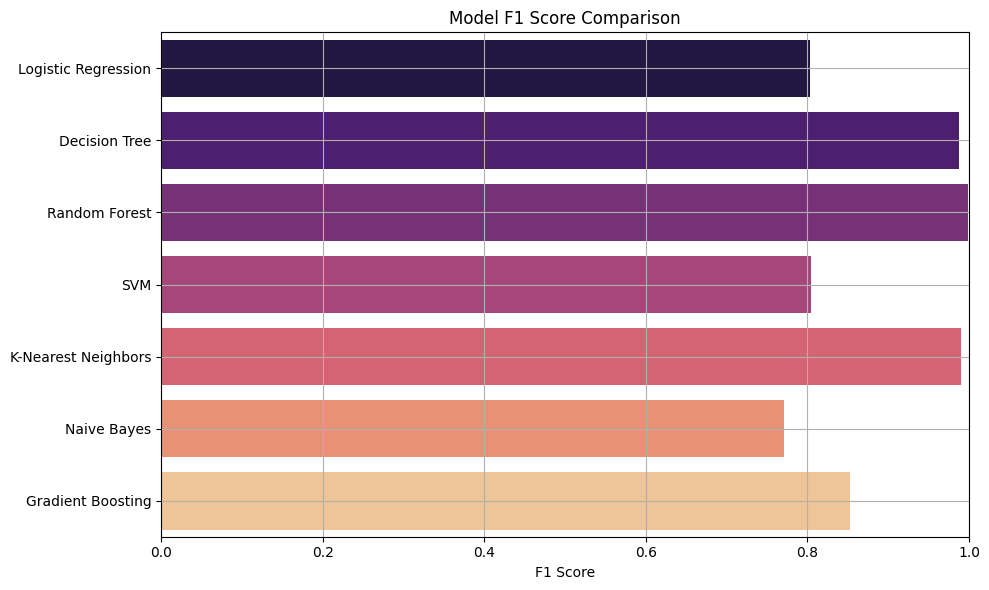


 Best Performing Model: Random Forest
    Accuracy: 0.9982
    F1 Score: 0.9983


In [12]:
# compairing the accuracy

# Accuracy comparison for models
plt.figure(figsize=(10, 6))
sns.barplot(
    x=list(accuracy_results.values()),
    y=list(accuracy_results.keys()),
    hue=list(accuracy_results.keys()),
    palette="coolwarm",
    legend=False
)
plt.xlabel('Accuracy')
plt.title('Model Accuracy Comparison')
plt.xlim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()

# F1 score comparison for models
plt.figure(figsize=(10, 6))
sns.barplot(
    x=list(f1_results.values()),
    y=list(f1_results.keys()),
    hue=list(f1_results.keys()),
    palette="magma",
    legend=False
)
plt.xlabel('F1 Score')
plt.title('Model F1 Score Comparison')
plt.xlim(0, 1)
plt.grid(True)
plt.tight_layout()
plt.show()


# choosing the best accurate model
best_model = max(accuracy_results, key=accuracy_results.get)
print(f"\n Best Performing Model: {best_model}")
print(f"    Accuracy: {accuracy_results[best_model]:.4f}")
print(f"    F1 Score: {f1_results[best_model]:.4f}")

In [7]:
# prediction
def get_win_probability(model, encoders, batting_team, bowling_team, venue,
                        runs_so_far, wickets_lost, balls_bowled, target):
    try:
        cum_wickets = wickets_lost
        cum_runs = runs_so_far
        balls_left = 120 - balls_bowled
        runs_left = target - runs_so_far
        wickets_left = 10 - wickets_lost
        current_rr = cum_runs / (balls_bowled / 6) if balls_bowled else 0
        required_rr = runs_left / (balls_left / 6) if balls_left else 0
        encoded_input = pd.DataFrame({
            'BattingTeam': [encoders['BattingTeam'].transform([batting_team])[0]],
            'team1': [encoders['team1'].transform([batting_team])[0]],
            'team2': [encoders['team2'].transform([bowling_team])[0]],
            'venue': [encoders['venue'].transform([venue])[0]],
            'cum_runs': [cum_runs],
            'runs_left': [runs_left],
            'cum_wickets': [cum_wickets],
            'wickets_left': [wickets_left],
            'balls_left': [balls_left],
            'current_run_rate': [current_rr],
            'required_run_rate': [required_rr],
            'target': [target]
        })

        win_prob = model.predict_proba(encoded_input)[0][1]
        return round(win_prob * 100, 2)

    except Exception as e:
        print("Prediction error:", e)
        return None


In [8]:
# Teams and venues
team_list = encoders['BattingTeam'].classes_.tolist()
venue_list = encoders['venue'].classes_.tolist()

print("\n Available Teams:")
for idx, team in enumerate(team_list, start=1):
    print(f"{idx}: {team}")

print("\n Available Venues:")
for idx, v in enumerate(venue_list, start=1):
    print(f"{idx}: {v}")

try:
    batting_idx = int(input("\nEnter the number for Batting Team: ")) - 1
    bowling_idx = int(input("Enter the number for Bowling Team: ")) - 1

    if batting_idx == bowling_idx:
        raise ValueError("Batting and Bowling teams must be different!")

    venue_idx = int(input("Enter the number for Venue: ")) - 1

    target = int(input("Enter Target Runs: "))
    runs_so_far = int(input("Enter Runs Scored So Far: "))
    wickets_lost = int(input("Enter Wickets Lost: "))
    balls_bowled = int(input("Enter Balls Bowled (0–120): "))
    if not (0 <= runs_so_far <= target):
        raise ValueError("Runs scored so far must be between 0 and the target.")
    if not (0 <= wickets_lost <= 10):
        raise ValueError("Wickets lost must be between 0 and 10.")
    if not (0 <= balls_bowled <= 120):
        raise ValueError("Balls bowled must be between 0 and 120.")
    batting_team = team_list[batting_idx]
    bowling_team = team_list[bowling_idx]
    venue = venue_list[venue_idx]

    prob = get_win_probability(model, encoders, batting_team, bowling_team, venue,
                               runs_so_far, wickets_lost, balls_bowled, target)
    
    print(f"\n Win Probability for {batting_team} is about: {prob}%")

except ValueError as ve:
    print(f" Input Error: {ve}")
except Exception as e:
    print(f" Unexpected Error: {e}")



 Available Teams:
1: Chennai Super Kings
2: Delhi Capitals
3: Gujarat Titans
4: Kolkata Knight Riders
5: Lucknow Super Giants
6: Mumbai Indians
7: Punjab Kings
8: Rajasthan Royals
9: Royal Challengers Bangalore
10: Sunrisers Hyderabad

 Available Venues:
1: Arun Jaitley Stadium
2: Barabati Stadium
3: Barsapara Cricket Stadium, Guwahati
4: Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow
5: Brabourne Stadium
6: Buffalo Park
7: De Beers Diamond Oval
8: Dr Dy Patil Sports Academy
9: Dr. Y.S. Rajasekhara Reddy Aca-Vdca Cricket Stadium
10: Dubai International Cricket Stadium
11: Eden Gardens
12: Himachal Pradesh Cricket Association Stadium
13: Holkar Cricket Stadium
14: Jsca International Stadium Complex
15: Kingsmead
16: M Chinnaswamy Stadium
17: Ma Chidambaram Stadium
18: Maharaja Yadavindra Singh International Cricket Stadium, Mullanpur
19: Maharashtra Cricket Association Stadium
20: Maharashtra Cricket Association Stadium, Pune
21: Narendra Modi Stadium, Ahmedabad



Enter the number for Batting Team:  1
Enter the number for Bowling Team:  2
Enter the number for Venue:  3
Enter Target Runs:  123
Enter Runs Scored So Far:  110
Enter Wickets Lost:  1
Enter Balls Bowled (0–120):  110



 Win Probability for Chennai Super Kings is about: 85.88%


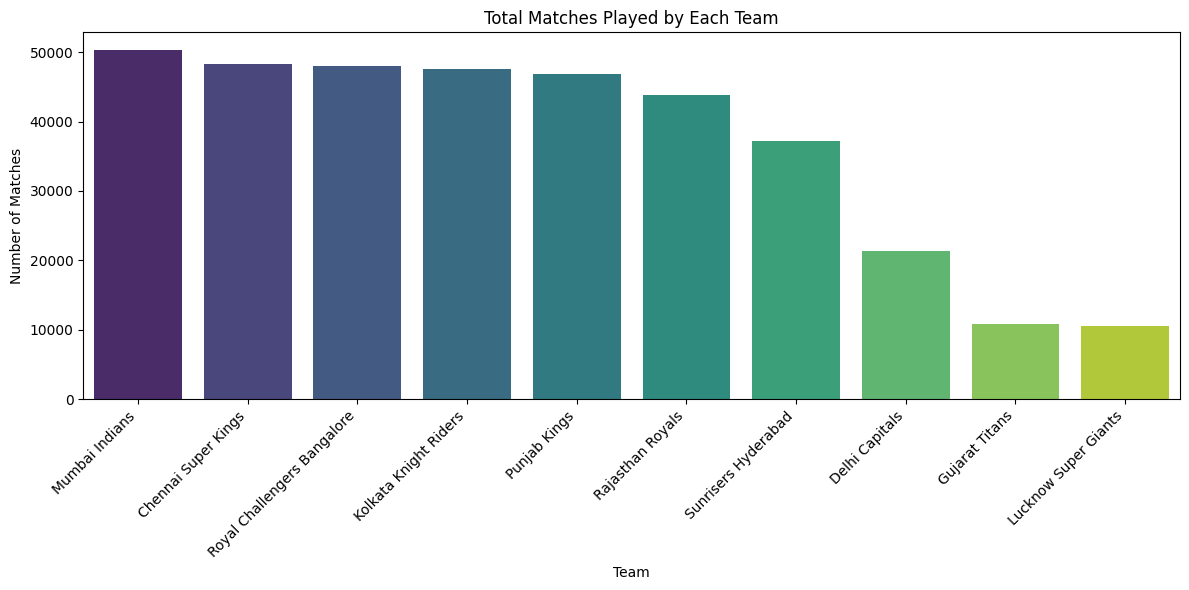

In [13]:
# Number of matches per team
plt.figure(figsize=(12, 6))
match_counts = pd.concat([df['team1'], df['team2']]).value_counts()
sns.barplot(
    x=match_counts.index,
    y=match_counts.values,
    hue=match_counts.index, 
    palette='viridis',    legend=False)       

plt.xticks(rotation=45, ha='right')
plt.title('Total Matches Played by Each Team')
plt.ylabel('Number of Matches')
plt.xlabel('Team')
plt.tight_layout()
plt.show()


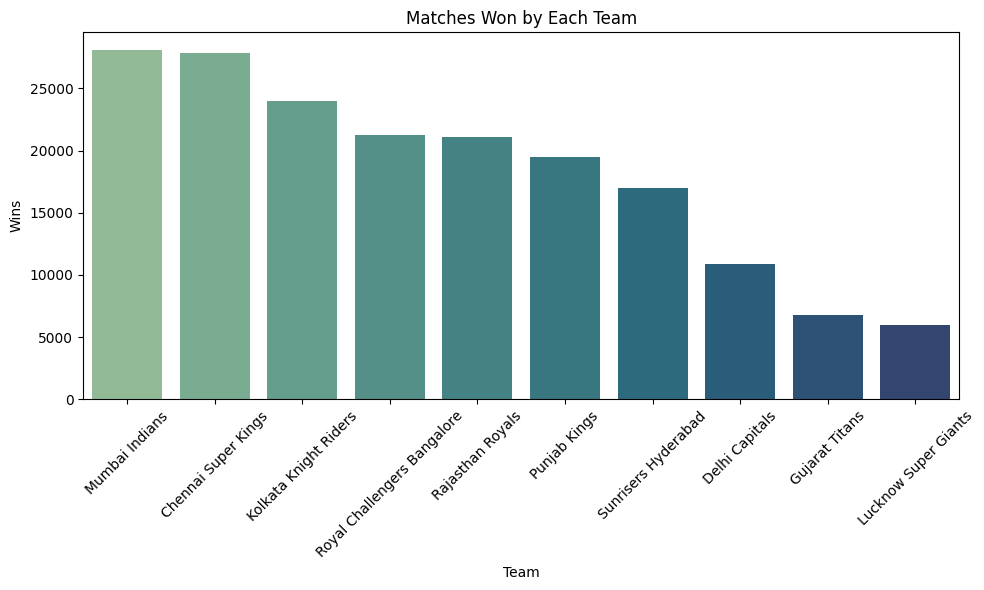

In [14]:
# Most wins by a team
plt.figure(figsize=(10, 6))
win_counts = df['winner'].value_counts()
sns.barplot(
    x=win_counts.index,
    y=win_counts.values,
    hue=win_counts.index, 
    palette='crest',
    legend=False)
plt.xticks(rotation=45)
plt.title('Matches Won by Each Team')
plt.ylabel('Wins')
plt.xlabel('Team')
plt.tight_layout()
plt.show()
